In [1]:
!pip install pandas matplotlib tqdm transformer_lens


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformer_lens.utils import test_prompt
from transformer_lens import HookedTransformer

In [2]:
from utils import plot_against_alt, get_first_order_df, print_mean_and_std, print_num_incorrect, compute_first_order_summary_stats

# GPT-2 Small

In [3]:
# load results
small_df = pd.read_csv('results/small_logits.csv')

In [4]:
print(small_df.columns)
print(small_df.shape)

Index(['template', 'PLACE', 'OBJECT', 'S', 'IO', 'text', 'prompt_toks',
       'logit_diff'],
      dtype='object')
(9313920, 8)


## Global Statistics

In [5]:
global_small_mean, global_small_std = print_mean_and_std(small_df)

Global mean: 3.7937727343427996
Global std: 1.9872322631118449


(array([5.29964248e-07, 2.64982124e-06, 1.05992850e-06, 3.70974974e-06,
        6.35957097e-06, 3.17978549e-06, 5.29964248e-06, 4.45169968e-05,
        1.64288917e-05, 6.20058170e-05, 1.67998667e-04, 2.04036235e-04,
        3.95883293e-04, 4.79087680e-04, 9.39626612e-04, 1.02230103e-03,
        2.23167945e-03, 2.52686953e-03, 3.87456862e-03, 6.48252268e-03,
        9.31465162e-03, 1.32824939e-02, 1.84120179e-02, 2.68734271e-02,
        3.45658581e-02, 4.56002437e-02, 5.97206112e-02, 7.27089750e-02,
        8.94834033e-02, 1.04274705e-01, 1.20987658e-01, 1.36091639e-01,
        1.50757870e-01, 1.65158058e-01, 1.76707569e-01, 1.88351414e-01,
        1.94703035e-01, 1.98062478e-01, 2.01169129e-01, 2.02901052e-01,
        1.97034878e-01, 1.95030553e-01, 1.90151172e-01, 1.83202811e-01,
        1.75763173e-01, 1.67501030e-01, 1.59303013e-01, 1.50518856e-01,
        1.40072201e-01, 1.31540306e-01, 1.20734865e-01, 1.10837253e-01,
        1.01472785e-01, 9.16000805e-02, 8.19144539e-02, 7.384786

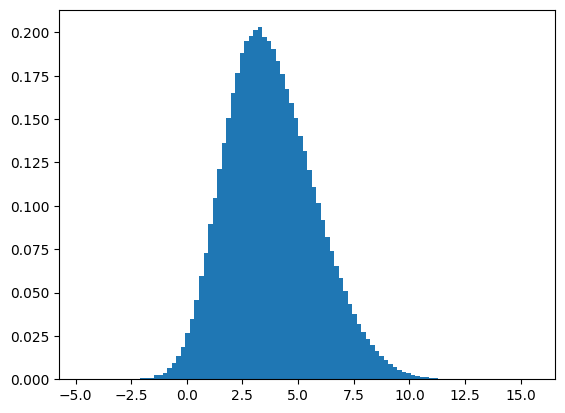

In [6]:
# plot full histogram
plt.hist(small_df['logit_diff'], bins=100,  density=True)

In [7]:
print_num_incorrect(small_df)

# examples with logit diff < 0:	 125583 out of 9313920
% examples with logit diff < 0:	 1.348%


## Digging Down

In [8]:
small_first_df = get_first_order_df(small_df)

Starting  template


100%|██████████| 15/15 [01:33<00:00,  6.20s/it]


Starting  PLACE


100%|██████████| 8/8 [00:55<00:00,  6.90s/it]


Starting  OBJECT


100%|██████████| 8/8 [00:56<00:00,  7.08s/it]


Starting  S


100%|██████████| 99/99 [09:51<00:00,  5.98s/it]


Starting  IO


100%|██████████| 99/99 [09:52<00:00,  5.98s/it]


In [11]:
small_first_df = compute_first_order_summary_stats(small_first_df, global_small_mean, global_small_std)

In [12]:
small_first_df.columns

Index(['col', 'val', 'mean', 'std', 'alt_mean', 'alt_std', 'global_mean_diff',
       'global_std_diff', 'relative_mean_diff', 'relative_std_diff'],
      dtype='object')

In [13]:
small_first_df.sort_values("global_mean_diff", ascending=False).head(10)

,col,val,mean,std,alt_mean,alt_std,global_mean_diff,global_std_diff,relative_mean_diff,relative_std_diff
55,S,Jeffrey,6.501107,1.692153,3.766147,1.970943,2.707334,0.295079,2.734960,0.278790
85,S,Bradley,6.236655,1.688759,3.768845,1.974531,2.442882,0.298473,2.467810,0.285772
66,S,Kenneth,5.900351,2.173847,3.772277,1.973683,2.106578,0.186615,2.128074,0.200164
43,S,Lisa,1.799079,1.359751,3.814127,1.982299,1.994694,0.627481,2.015048,0.622548
3,template,When [B] and [A] got a [OBJECT] at the [PLACE]...,5.769635,1.697381,3.652640,1.930440,1.975863,0.289851,2.116996,0.233059
86,S,Alexander,5.687984,1.680786,3.774444,1.980802,1.894212,0.306446,1.913540,0.300016
5,template,When [B] and [A] got a [OBJECT] at the [PLACE]...,5.681712,1.696412,3.658920,1.937223,1.887940,0.290820,2.022792,0.240811
199,IO,Bradley,1.975523,1.668847,3.812326,1.981638,1.818250,0.318386,1.836803,0.312792
72,S,Amanda,1.993331,1.423134,3.812145,1.983761,1.800442,0.564099,1.818814,0.560627
58,S,Benjamin,5.457250,1.992060,3.776798,1.979993,1.663478,0.004828,1.680452,0.012067


In [14]:
small_first_df.sort_values("relative_mean_diff", ascending=False).head(10)

,col,val,mean,std,alt_mean,alt_std,global_mean_diff,global_std_diff,relative_mean_diff,relative_std_diff
55,S,Jeffrey,6.501107,1.692153,3.766147,1.970943,2.707334,0.295079,2.734960,0.278790
85,S,Bradley,6.236655,1.688759,3.768845,1.974531,2.442882,0.298473,2.467810,0.285772
66,S,Kenneth,5.900351,2.173847,3.772277,1.973683,2.106578,0.186615,2.128074,0.200164
3,template,When [B] and [A] got a [OBJECT] at the [PLACE]...,5.769635,1.697381,3.652640,1.930440,1.975863,0.289851,2.116996,0.233059
5,template,When [B] and [A] got a [OBJECT] at the [PLACE]...,5.681712,1.696412,3.658920,1.937223,1.887940,0.290820,2.022792,0.240811
43,S,Lisa,1.799079,1.359751,3.814127,1.982299,1.994694,0.627481,2.015048,0.622548
86,S,Alexander,5.687984,1.680786,3.774444,1.980802,1.894212,0.306446,1.913540,0.300016
199,IO,Bradley,1.975523,1.668847,3.812326,1.981638,1.818250,0.318386,1.836803,0.312792
72,S,Amanda,1.993331,1.423134,3.812145,1.983761,1.800442,0.564099,1.818814,0.560627
58,S,Benjamin,5.457250,1.992060,3.776798,1.979993,1.663478,0.004828,1.680452,0.012067


In [17]:
small_first_df.sort_values("mean", ascending=True).head(10)

,col,val,mean,std,alt_mean,alt_std,global_mean_diff,global_std_diff,relative_mean_diff,relative_std_diff
43,S,Lisa,1.799079,1.359751,3.814127,1.982299,1.994694,0.627481,2.015048,0.622548
199,IO,Bradley,1.975523,1.668847,3.812326,1.981638,1.818250,0.318386,1.836803,0.312792
72,S,Amanda,1.993331,1.423134,3.812145,1.983761,1.800442,0.564099,1.818814,0.560627
48,S,Shannon,2.218303,2.007182,3.809849,1.980579,1.575470,0.019950,1.591546,0.026603
75,S,Vanessa,2.315721,1.543558,3.808855,1.985587,1.478052,0.443674,1.493134,0.442030
10,template,"Then, [B] and [A] had a long argument, and aft...",2.348365,1.598096,3.897016,1.972019,1.445408,0.389136,1.548651,0.373923
44,S,Mary,2.370384,1.602570,3.808297,1.985522,1.423388,0.384663,1.437913,0.382952
185,IO,David,2.377378,1.413634,3.808226,1.987037,1.416395,0.573598,1.430848,0.573403
82,S,Amy,2.383882,1.332780,3.808159,1.987655,1.409891,0.654453,1.424278,0.654875
6,template,"Then, [B] and [A] had a long argument. Afterwa...",2.405721,1.682761,3.892919,1.970141,1.388052,0.304472,1.487198,0.287381


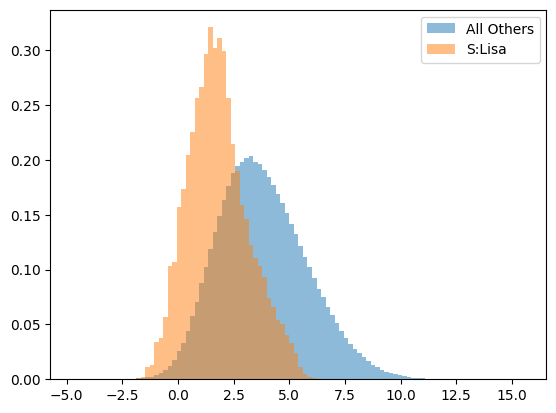

In [18]:
plot_against_alt(small_df, 'S', 'Lisa', label_prefix="")

In [19]:
small_s_df = small_df[small_df["S"] == "Lisa"]

In [20]:
small_s_second_df = get_first_order_df(small_s_df)

Starting  template


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


Starting  PLACE


100%|██████████| 8/8 [00:00<00:00, 13.16it/s]


Starting  OBJECT


100%|██████████| 8/8 [00:00<00:00, 13.29it/s]


Starting  S


100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Starting  IO


100%|██████████| 98/98 [00:06<00:00, 14.22it/s]


In [21]:
small_s_second_df.sort_values("mean", ascending=True).head(10)

,col,val,mean,std,alt_mean,alt_std
106,IO,Katie,0.017770,1.187264,1.817443,1.349228
44,IO,Alicia,0.196236,1.065318,1.815603,1.352604
102,IO,Michelle,0.206026,0.938098,1.815502,1.353694
74,IO,Samantha,0.232368,1.106246,1.815231,1.352706
90,IO,Lindsay,0.275709,0.938980,1.814784,1.354523
39,IO,Sara,0.385149,1.315619,1.813656,1.352529
36,IO,Laura,0.583636,0.955124,1.811610,1.357646
77,IO,Stephanie,0.594710,1.121147,1.811495,1.356440
100,IO,Kristen,0.614060,1.037480,1.811296,1.357303
75,IO,Christina,0.652787,1.077171,1.810897,1.357331


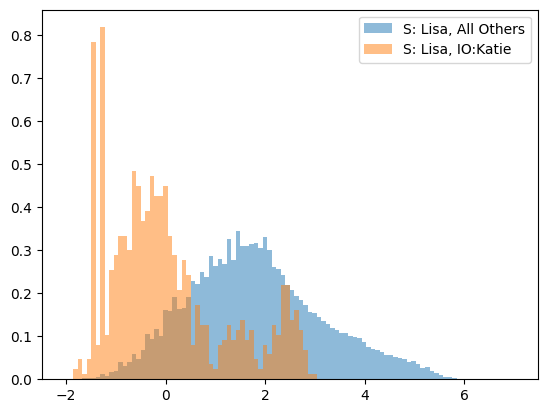

In [23]:
plot_against_alt(small_s_df, "IO", "Katie", label_prefix="S: Lisa, ")

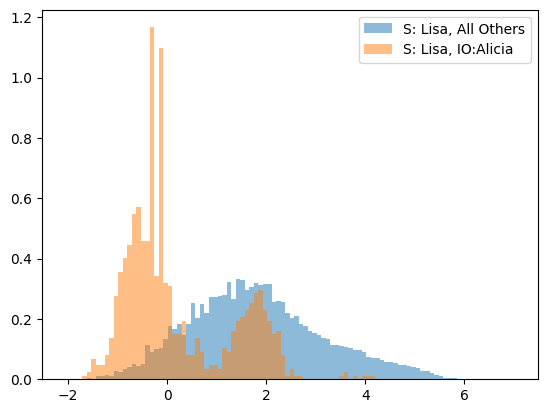

In [24]:
plot_against_alt(small_s_df, "IO", "Alicia", label_prefix="S: Lisa, ")

In [25]:
model = HookedTransformer.from_pretrained("gpt2")
tokenizer = model.tokenizer

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [26]:
small_s_io_df = small_s_df[small_s_df["IO"] == "Alicia"]
toks = small_s_io_df.iloc[0]['prompt_toks'][1:-1].split(', ')
toks = [int(t) for t in toks]
prompt = tokenizer.decode(toks)
prompt

'Then, Lisa and Alicia were working at the store. Lisa decided to give a computer to'

In [27]:
test_prompt(prompt, "Alicia", model)

Tokenized prompt: ['<|endoftext|>', 'Then', ',', ' Lisa', ' and', ' Alicia', ' were', ' working', ' at', ' the', ' store', '.', ' Lisa', ' decided', ' to', ' give', ' a', ' computer', ' to']
Tokenized answer: [' Alicia']


Performance on answer token:
Rank: 4        Logit: 14.68 Prob:  7.43% Token: | Alicia|

Top 0th token. Logit: 15.83 Prob: 23.56% Token: | her|
Top 1th token. Logit: 15.25 Prob: 13.18% Token: | Lisa|
Top 2th token. Logit: 15.12 Prob: 11.57% Token: | the|
Top 3th token. Logit: 14.90 Prob:  9.28% Token: | them|
Top 4th token. Logit: 14.68 Prob:  7.43% Token: | Alicia|
Top 5th token. Logit: 13.75 Prob:  2.93% Token: | a|
Top 6th token. Logit: 13.19 Prob:  1.68% Token: | one|
Top 7th token. Logit: 13.05 Prob:  1.47% Token: | their|
Top 8th token. Logit: 12.51 Prob:  0.85% Token: | him|
Top 9th token. Logit: 12.30 Prob:  0.69% Token: | someone|


Ranks of the answer tokens: [(' Alicia', 4)]

# GPT-2 Medium

In [28]:
med_df = pd.read_csv('results/medium_logits.csv')

In [29]:
print(med_df.columns)
print(med_df.shape)

Index(['template', 'PLACE', 'OBJECT', 'S', 'IO', 'text', 'prompt_toks',
       'logit_diff'],
      dtype='object')
(9313920, 8)


## Global Statistics

In [30]:
global_med_mean, global_med_std = print_mean_and_std(med_df)

Global mean: 4.179841006053221
Global std: 1.4802102392905077


(array([1.55343940e-06, 2.33015910e-06, 2.33015910e-06, 8.54391672e-06,
        1.94179925e-05, 4.11661442e-05, 7.06814928e-05, 1.13401076e-04,
        1.99616963e-04, 3.05250843e-04, 5.18072041e-04, 8.69926066e-04,
        1.30100550e-03, 2.03422890e-03, 2.95231159e-03, 4.58109280e-03,
        6.42968569e-03, 9.15985544e-03, 1.28943238e-02, 1.76059055e-02,
        2.30980905e-02, 3.07992663e-02, 3.89975428e-02, 4.98956969e-02,
        6.15472691e-02, 7.47173284e-02, 8.84567232e-02, 1.03941407e-01,
        1.19290942e-01, 1.36631986e-01, 1.52790086e-01, 1.69653447e-01,
        1.85347069e-01, 2.00081442e-01, 2.13763359e-01, 2.26381171e-01,
        2.35935600e-01, 2.44663599e-01, 2.49223720e-01, 2.53818794e-01,
        2.56124098e-01, 2.59530014e-01, 2.59027477e-01, 2.59518363e-01,
        2.55362136e-01, 2.49586449e-01, 2.46958806e-01, 2.31202270e-01,
        2.26771084e-01, 2.14029774e-01, 1.97947016e-01, 1.87685772e-01,
        1.73025964e-01, 1.62708020e-01, 1.45370859e-01, 1.335243

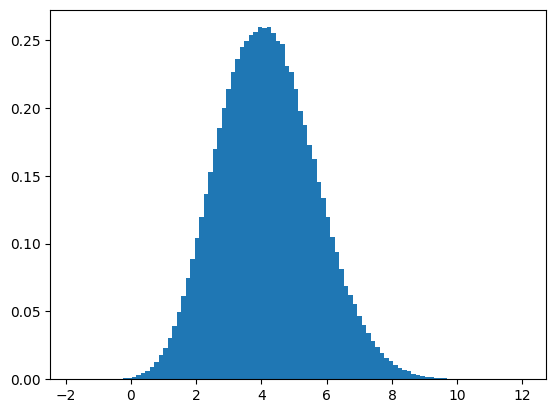

In [31]:
# plot full histogram
plt.hist(med_df['logit_diff'], bins=100,  density=True)

In [32]:
print_num_incorrect(med_df)

# examples with logit diff < 0:	 4143 out of 9313920
% examples with logit diff < 0:	 0.044%


## Digging Down

In [ ]:
med_first_df = get_first_order_df(med_df)
med_first_df = compute_first_order_summary_stats(med_first_df, global_med_mean, global_med_std)

Starting  template


100%|██████████| 15/15 [01:31<00:00,  6.07s/it]


Starting  PLACE


100%|██████████| 8/8 [00:50<00:00,  6.33s/it]


Starting  OBJECT


100%|██████████| 8/8 [00:49<00:00,  6.17s/it]


Starting  S


100%|██████████| 99/99 [09:38<00:00,  5.84s/it]


Starting  IO


 29%|██▉       | 29/99 [02:51<07:31,  6.46s/it]

In [ ]:
med_first_df.sort_values("global_mean_diff", ascending=False).head(10)

# GPT-2 Large

In [ ]:
large_df = pd.read_csv('results/large_logits.csv')

In [ ]:
print(large_df.columns)
print(large_df.shape)

## Global Statistics

In [ ]:
global_large_mean, global_large_std = print_mean_and_std(large_df)

In [ ]:
# plot full histogram
plt.hist(large_df['logit_diff'], bins=100,  density=True)

In [ ]:
print_num_incorrect(large_df)

In [ ]:
large_first_df = get_first_order_df(large_df)
large_first_df = compute_first_order_summary_stats(large_first_df, global_large_mean, global_large_std)

In [ ]:
large_first_df.sort_values("global_mean_diff", ascending=False).head(10)